# Systemy rekomendacyjne – zadanie MovieLens 100K

## 1. Przegląd danych

1. **Podaj liczbę filmów dla dzieci.**  
2. **Pokaż rozkład ocen filmów z 1995 roku.**  
3. **Podaj średnią ocen wszystkich filmów akcji oraz 3 filmy najwyżej oceniane.**


Liczba filmów dla dzieci: 122


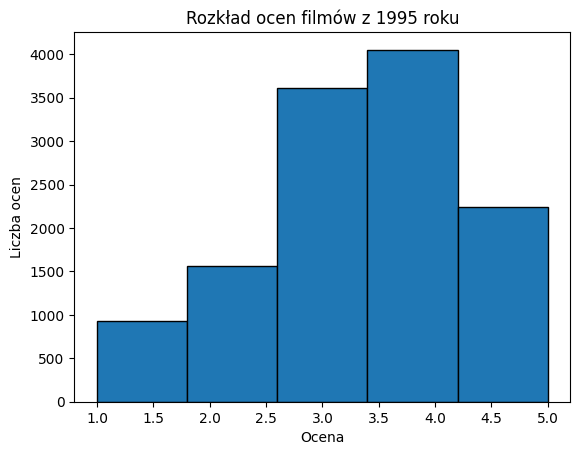

Średnia ocen filmów akcji: 3.48
Top 3 najwyżej oceniane filmy akcji:
    movie_id                           title    rating
11        50                Star Wars (1977)  4.358491
28       127           Godfather, The (1972)  4.283293
38       174  Raiders of the Lost Ark (1981)  4.252381


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ratings_path = 'u.data'
ratings_cols = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv(ratings_path, sep='	', names=ratings_cols, engine='python')

movies_path = 'u.item'
movie_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url',
              'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy',
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv(movies_path, sep='|', names=movie_cols, encoding='latin-1')

# 1. Liczba filmów dla dzieci
num_children = movies["Children's"].sum()
print(f'Liczba filmów dla dzieci: {int(num_children)}')

# 2. Rozkład ocen filmów z 1995
years = movies['title'].str.extract(r'\((\d{4})\)', expand=False).astype(float)
movies['year'] = years
movies_1995 = movies[movies['year'] == 1995]
ratings_1995 = ratings.merge(movies_1995[['movie_id']], left_on='item_id', right_on='movie_id')

plt.figure()
ratings_1995['rating'].plot(kind='hist', bins=5, edgecolor='black')
plt.xlabel('Ocena')
plt.ylabel('Liczba ocen')
plt.title('Rozkład ocen filmów z 1995 roku')
plt.show()

# 3. Średnia ocena filmów akcji oraz top 3 najwyżej oceniane filmy akcji
ratings_movies = ratings.merge(movies[['movie_id', 'title', 'Action']], left_on='item_id', right_on='movie_id')
action_ratings = ratings_movies[ratings_movies['Action'] == 1]
mean_action_rating = action_ratings['rating'].mean()
print(f'Średnia ocen filmów akcji: {mean_action_rating:.2f}')

action_movie_means = action_ratings.groupby(['movie_id', 'title'])['rating'].mean().reset_index()
top3_action_movies = action_movie_means.sort_values('rating', ascending=False).head(3)
print('Top 3 najwyżej oceniane filmy akcji:')
print(top3_action_movies)

## 2. System rekomendacyjny

**kNN with means**

In [2]:
from surprise import Dataset, Reader, KNNWithMeans, SVD
from surprise.model_selection import GridSearchCV, cross_validate
import numpy as np
import re


reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(ratings[["user_id", "item_id", "rating"]], reader)

param_grid = {
    "k": list(range(3, 11)),           
    "sim_options": {
        "name": ["cosine"],            
        "user_based": [True]           
    }
}

gs_knn_mean = GridSearchCV(
    algo_class=KNNWithMeans,
    param_grid=param_grid,
    measures=["rmse"],
    cv=3,              
    n_jobs=-1
)

gs_knn_mean.fit(data)

print("Najlepszy wynik (RMSE):", round(gs_knn_mean.best_score["rmse"], 4))
print("Najlepsze parametry:", gs_knn_mean.best_params["rmse"])

best_k = gs_knn_mean.best_params["rmse"]["k"]
best_sim_options = gs_knn_mean.best_params["rmse"]["sim_options"]

print(">>> Wybrane k (z GridSearch):", best_k)


Najlepszy wynik (RMSE): 0.9917
Najlepsze parametry: {'k': 10, 'sim_options': {'name': 'cosine', 'user_based': True}}
>>> Wybrane k (z GridSearch): 10


kNN  liczy predykcję jako ważoną średnią ocen sąsiadów dla danego filmu.
kNNWithMeans robi to samo, ale najpierw odejmuje średnią ocenę każdego sąsiada, a na końcu dodaje średnią ocenę użytkownika, dla którego przewidujemy ocenę.

In [3]:

algo_svd = SVD(random_state=42)

algo_knn_mean = KNNWithMeans(k=best_k, sim_options=best_sim_options)

cv_svd = cross_validate(algo_svd, data, measures=["RMSE"], cv=5, verbose=True)
cv_knn_mean = cross_validate(algo_knn_mean, data, measures=["RMSE"], cv=5, verbose=True)

mean_rmse_svd = np.mean(cv_svd["test_rmse"])
mean_rmse_knn_mean = np.mean(cv_knn_mean["test_rmse"])

print("\nŚredni RMSE SVD (CV=5):", round(mean_rmse_svd, 4))
print("Średni RMSE KNNWithMeans (CV=5, k={}): {:.4f}".format(best_k, mean_rmse_knn_mean))

if mean_rmse_knn_mean < mean_rmse_svd:
    print("\nWynik: KNNWithMeans z k={} jest lepszy (niższy RMSE).".format(best_k))
else:
    print("\nWynik: SVD jest lepszy (niższy RMSE).")


Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9316  0.9316  0.9428  0.9399  0.9393  0.9370  0.0046  
Fit time          1.04    1.06    1.06    1.12    1.17    1.09    0.05    
Test time         0.09    0.17    0.10    0.17    0.12    0.13    0.04    
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9762  0.9851  0.9895  0.9813  0.9948  0.9854  0.0064  
Fit time          0.98    1.35    1.10    1.10    0.61    1.03 

In [ ]:
import numpy as np

trainset = data.build_full_trainset()
svd_full = SVD(random_state=42)
svd_full.fit(trainset)
id_col = "movie_id"

# wektory itemów z Surprise (po fit)
item_factors = svd_full.qi
norms = np.linalg.norm(item_factors, axis=1, keepdims=True) + 1e-8
norm_item_factors = item_factors / norms


def get_movie_id_from_trainset_by_title(fragment):
   
    fragment = fragment.lower().strip()

    candidates = []
    for inner_iid in trainset.all_items():
        raw = trainset.to_raw_iid(inner_iid)   
        raw_int = int(raw)

        title = movies.loc[movies[id_col] == raw_int, "title"].iloc[0]
        t_low = title.lower()

      
        if len(fragment) <= 2:
            if re.search(rf"\b{re.escape(fragment)}\b", t_low):
                candidates.append((raw_int, title))
        else:
            if fragment in t_low:
                candidates.append((raw_int, title))

    if not candidates:
        raise ValueError(f"Nie znalazłem filmu w trainset z fragmentem tytułu: {fragment}")

    print("Znalezione dopasowania (pierwsze 10):")
    for mid, t in candidates[:10]:
        print(f"- {mid}: {t}")

    return candidates[0][0]  

In [7]:
def recommend_for_movies_surprise(movie_ids, top_n=5):
    """
    Rekomendacje podobnych filmów do listy movie_ids na podstawie wektorów itemów z Surprise SVD.
    """
    target_inner_idxs = []
    for mid in movie_ids:
        inner = trainset.to_inner_iid(int(mid))
        target_inner_idxs.append(inner)

    target_vecs = norm_item_factors[target_inner_idxs]
    user_pref = target_vecs.mean(axis=0)
    user_pref_norm = user_pref / (np.linalg.norm(user_pref) + 1e-8)

    sims = norm_item_factors @ user_pref_norm
    sorted_inner = np.argsort(sims)[::-1]

    recommendations = []
    target_set = set(int(x) for x in movie_ids)

    for inner_idx in sorted_inner:
        raw = trainset.to_raw_iid(inner_idx)
        raw_int = int(raw)

        if raw_int in target_set:
            continue

        title = movies.loc[movies[id_col] == raw_int, "title"].iloc[0]
        recommendations.append((raw_int, title, float(sims[inner_idx])))

        if len(recommendations) >= top_n:
            break

    return recommendations
nev_id = get_movie_id_from_trainset_by_title("NeverEnding Story III")
pi_id  = get_movie_id_from_trainset_by_title("2001: A Space Odyssey")

recs = recommend_for_movies_surprise([nev_id, pi_id], top_n=5)

print("Rekomendowane filmy po obejrzeniu 'NeverEnding Story III' i '2001: A Space Odyssey':")
for mid, title, score in recs:
    print(f"{title} (movie_id={mid}) - podobieństwo: {score:.3f}")

Znalezione dopasowania (pierwsze 10):
- 548: NeverEnding Story III, The (1994)
Znalezione dopasowania (pierwsze 10):
- 135: 2001: A Space Odyssey (1968)
Rekomendowane filmy po obejrzeniu 'NeverEnding Story III' i '2001: A Space Odyssey':
Godfather, The (1972) (movie_id=127) - podobieństwo: 0.405
Godfather: Part II, The (1974) (movie_id=187) - podobieństwo: 0.390
Shining, The (1980) (movie_id=200) - podobieństwo: 0.342
This Is Spinal Tap (1984) (movie_id=209) - podobieństwo: 0.338
Monty Python and the Holy Grail (1974) (movie_id=168) - podobieństwo: 0.312
